In [ ]:


env = gym.make('Breakout-v0')
env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for _ in range(100):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)

In [ ]:
import gym, PIL
env = gym.make('SpaceInvaders-v0')
array = env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))



In [12]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
import os
os.chdir('/home/yuewang/project/moment_rl')

In [14]:
import logging
from agent import *
from component import *
from utils import *
import argparse
import time
import pickle
import matplotlib.pyplot as plt

In [26]:
class Args():
    def __init__(self):
        #self.task = 'MontezumaRevenge'
        self.task = 'Venture'
        self.mode = 'dqn_iue'
        self.moment_hidden =[512]
        self.moment_num = 1
        self.moment_beta = [0.5]
        self.suff = '53'
        self.rep = 125000
        self.oldornew = 'o'
        

In [27]:
args = Args()
task_name = args.task+ 'NoFrameskip-v4'
config = Config()

config.history_length = 4

config.test_task_fn  = lambda: test_PixelAtari(task_name, no_op=30, frame_skip=4, normalized_state=False)
action_dim = config.test_task_fn().action_dim
config.network_fn = lambda optimizer_fn: NatureConvNet(config.history_length, action_dim, optimizer_fn)
config.model = config.network_fn(None)
config.test_task = config.test_task_fn()
config.model_save_root = './model_save'

[2018-01-10 14:38:01,414] Making new env: VentureNoFrameskip-v4
[2018-01-10 14:38:01,651] Making new env: VentureNoFrameskip-v4


In [28]:
if args.oldornew == 'o':
    config.logname = '_'.join([task_name , args.mode , str(len(args.moment_hidden)) , str(args.moment_num)]+[str(x) for x in args.moment_hidden] +    [str(x) for x in args.moment_beta]+[args.suff])
elif args.oldornew == 'n':
    config.logname = '_'.join(
        [task_name, args.mode, str(len(args.moment_hidden)), str(args.var), str(args.exploration_beta), str(args.mix_beta),
         args.suff])
else:
    print('error old or new!')
    assert  1==2
loginfo =  config.logname.split('_')

env_name = loginfo[0]
# mode = loginfo[1]
# moment_num = loginfo[2]
# moment_hidden = loginfo[3:3 + moment_num]
# moment_beta = loginfo[3 + moment_num: 3 + 2 * moment_num]
suff = loginfo[-1]
model_path_root =  config.model_save_root
model_path = model_path_root

if not os.path.exists(model_path):
    print('error! no ', model_path)

model_path_env = env_name
model_path = os.path.join(model_path, model_path_env)
if not os.path.exists(model_path):
    os.mkdir(model_path)

model_path_setting = '_'.join(loginfo)
# print(1,model_path_setting)
model_path = os.path.join(model_path, model_path_setting)
# print(2,model_path)
if not os.path.exists(model_path):
    print('error! no ', model_path)

allmodel = os.listdir(model_path)
allmodel = [x for x in allmodel if '.pkl' not in x and '.txt' not in x]

In [29]:

def episode(config, max_step):
    task = config.test_task
    model = config.model



    episode_start_time = time.time()
    state =  task.reset()
    history_buffer = [np.zeros_like(state)] *  config.history_length


    history_buffer.pop(0)
    history_buffer.append(state)
    state = np.vstack( history_buffer)
    total_reward = 0.0
    steps = 0
    img = plt.imshow(task.env.render(mode='rgb_array')) # only call this once
 
    while True:


        value = model.predict(np.stack([ task.normalize_state(state)]), False)
        value = value.cpu().data.numpy().flatten()
        action = np.argmax(value)

        next_state, reward, done, info =  task.step(action)
        img.set_data(task.env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        True_reward = info[-1]
        done = (done or (max_step and steps > max_step))
        history_buffer.pop(0)
        history_buffer.append(next_state)
        next_state = np.vstack(history_buffer)
        total_reward += np.sum(True_reward  )
        steps += 1
        state = next_state

        if done:
            break

    return(steps , total_reward)

In [30]:
mean_reward = {}
std_reward = {}
allmodel_info = [[x,int(x.split('_')[-1])] for x in allmodel]
allmodel_info.sort(key=lambda x:x[1])
allmodel_info.reverse()

In [37]:
this_model_info = allmodel_info[0]
time_step = this_model_info[1]
this_model = this_model_info[0]
config.model.load_state_dict(torch.load(os.path.join(model_path,this_model)))


KeyboardInterrupt: 

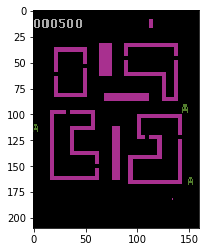

In [38]:
step_last = args.rep
all_rewards =[]
n=0
step , reward = episode(config,step_last)

In [ ]:
print(step , reward)


In [65]:
this_model_info

['VentureNoFrameskip-v4_dqn_iue_1_1_512_0.5_53_1575', 1575]